### Quantized Transfer Learning for Object Detection
#### Finetuning pretrained model on detecting foxes

In [34]:
# Imports

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights


#### Load and Transform Data

In [23]:
# script to separate finetuning images into train and validation folders

'''import random
import shutil

def split_images(input_folder, output_train_folder, output_val_folder, val_percentage=0.3):
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_val_folder, exist_ok=True)
    
    images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    num_val = int(len(images) * val_percentage)
    val_images = random.sample(images, num_val)
    
    for img in val_images:
        shutil.move(os.path.join(input_folder, img), os.path.join(output_val_folder, img))
        
    for img in os.listdir(input_folder):
        shutil.move(os.path.join(input_folder, img), os.path.join(output_train_folder, img))

input_folder = "data/possum"
output_train_folder = "data/train"
output_val_folder = "data/val"

split_images(input_folder, output_train_folder, output_val_folder)'''

'import random\nimport shutil\n\ndef split_images(input_folder, output_train_folder, output_val_folder, val_percentage=0.3):\n    os.makedirs(output_train_folder, exist_ok=True)\n    os.makedirs(output_val_folder, exist_ok=True)\n    \n    images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]\n    num_val = int(len(images) * val_percentage)\n    val_images = random.sample(images, num_val)\n    \n    for img in val_images:\n        shutil.move(os.path.join(input_folder, img), os.path.join(output_val_folder, img))\n        \n    for img in os.listdir(input_folder):\n        shutil.move(os.path.join(input_folder, img), os.path.join(output_train_folder, img))\n\ninput_folder = "data/possum"\noutput_train_folder = "data/train"\noutput_val_folder = "data/val"\n\nsplit_images(input_folder, output_train_folder, output_val_folder)'

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/camera_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [25]:
print(class_names)

['foxes', 'possum', 'raccoon']


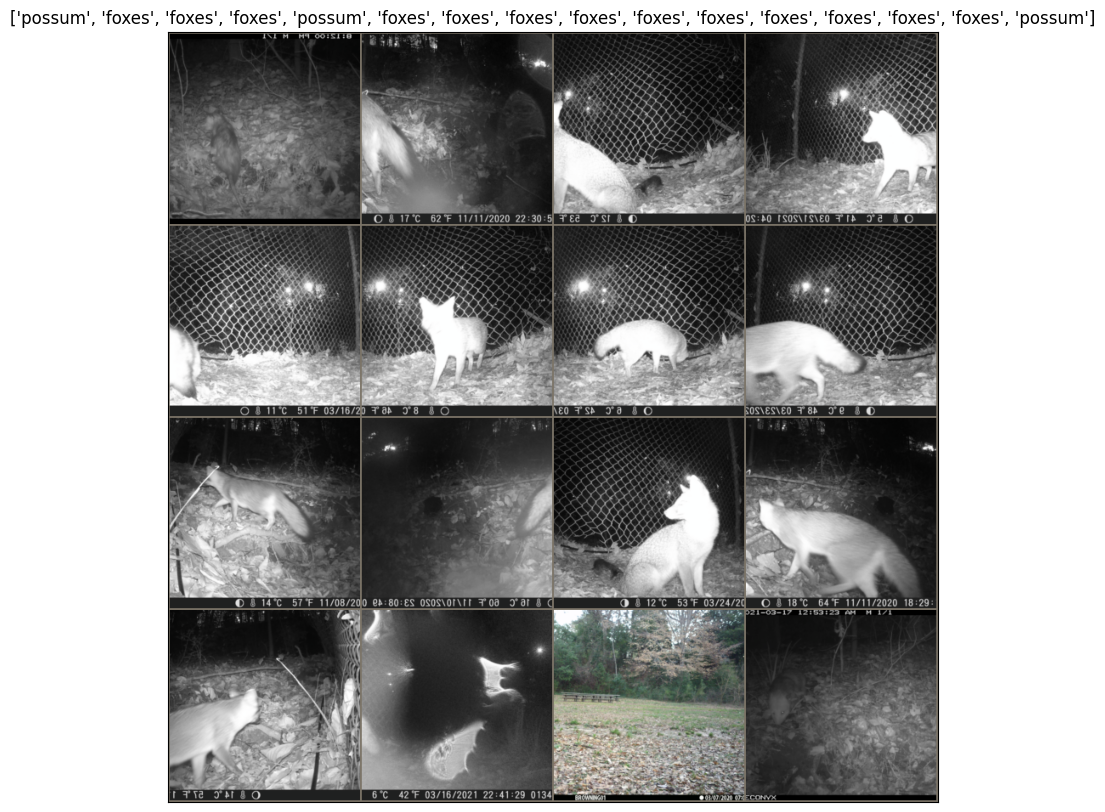

In [26]:

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

#### Generic functions for model training & prediction visualization

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Generic function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [28]:
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [29]:
# Helper function for creating a model with a custom head

from torch import nn

def create_combined_model(model_fe, num_ftrs):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model


#### Finetuning the model

In this part, we create a quantized feature extractor after fine tuning on the data-set of interest, so this is a way to get better accuracy with transfer learning while having the benefits of quantization. Note that in our specific example, the training set is really small so the benefits of fine tuning the entire model is not apparent. However, the procedure shown here will improve accuracy for transfer learning with larger datasets.

In [38]:
# Choose model (in our case mobilenet-V2)
model = models.quantization.mobilenet_v2(weights=MobileNet_V2_Weights, progress=True, quantize=False)
num_ftrs = model.classifier[1].in_features

print(num_ftrs)



1280


In [ ]:
# The pretrained feature extractor must be quantizable. To make sure it is quantizable, perform the following steps:

# Step 1: Fuse (Conv, BN, ReLU), (Conv, BN), and (Conv, ReLU)
model.train()
model.fuse_model()

# Step 2: Connect the feature extractor with a custom head. This requires dequantizing the output of the feature extractor.
model_ft = create_combined_model(model, num_ftrs)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration

# Step 3: Insert fake-quantization modules
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

# As step (4), you can start “finetuning” the model, and after that convert it to a fully quantized version (Step 5).

In [ ]:
# Step 4: Finetune the whole model, which in general will lead to higher accuracy. However, due to the small training set used here, we end up overfitting to the training set.

import torch.optim as optim

for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25, device=device)

# Step 5: Convert to quantized model to be used on Raspberry Pi device

from torch.quantization import convert

model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)